## Analysing model performance

This notebook reproduces the model performance analysis from the section _Model size drives average performance_. Model average performances are calculated and correlated to model size.

In [22]:
# General imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, sem
import json

In [31]:
# Import some useful lists
external_list_file = '../data/external/lists.json'

# Read the json lists from the external list file
lists = json.load(open(external_list_file))

# Extract the relevant lists from the data
tasks = lists['tasks']
task_difficulty = lists['task_difficulty']
models = lists['models']
model_sizes = lists['model_sizes']
model_names = lists['model_names']
model_names_size_ordered = lists['model_names_size_ordered']
model_palette = lists['model_palette']
model_architectures = lists['model_architectures']

Define a function to extract a CI range.

In [20]:
def get_CI_range(data, confidence=0.95):
  '''
  Output:
    Difference between the mean and the lower boundary of the 95% CI around the mean.
  '''
  confidence_interval = scipy.stats.norm.interval(
    alpha=confidence,
    loc=np.mean(data),
    scale=scipy.stats.sem(data)
  )
  
  interval = np.mean(data) - confidence_interval[0]
  
  return interval

Import the data and aggregate it as required.

In [23]:
# Import the data
perf_data = pd.read_pickle('../data/processed/perf_vectors.pkl')

# Extract average performance data
model_avg_seed = [[np.mean(perf_data[m][s]) for s in range(20)] for m in models]
models_avg = [np.mean(model_avg_seed[m]) for m in range(len(models))]
models_sem_seed = [sem(model_avg_seed[m]) for m in range(len(models))]
models_ci_seed = [get_CI_range(model_avg_seed[m]) for m in range(len(models))]
# Make an average performance data frame
avg_perf_df = pd.DataFrame({
    'model': models,
    'size': model_sizes.values(),
    'model_avg_performance': models_avg,
    'model_sem_seed': models_sem_seed,
    'model_ci_seed': models_ci_seed,
})

# Make a task-wise average performance dictionary
task_perf = {
    m: {
        t: [perf_data[m][s][i] for s in range(20)]
    for i, t in enumerate(tasks)
    }
    for m in models
}

# Make an easy v challenging task aggregation
task_difficulty_perf = {
    m: {
        'easy': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='easy'],
        'challenging': [np.mean(task_perf[m][t]) for t in tasks if task_difficulty[t]=='hard']
    }
    for m in models
}

# Make an average per task of model performance
avg_task_perf = {
    m: {
        t: {
            'mean': np.mean([perf_data[m][s][i] for s in range(20)]),
            'sem': sem([perf_data[m][s][i] for s in range(20)]),
            'ci': get_CI_range([perf_data[m][s][i] for s in range(20)])
        }
    for i, t in enumerate(tasks)
    }
    for m in models
}

Fetch the consistency results to use as noise ceilings.

In [24]:
# Extract consistency data
consistency_data = pd.read_pickle('../data/processed/perf_vectors.pkl')

# Extract the consistency across seeds
acc_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['accuracy'])[1, 0] for s in range(20)] for m in models]
# Make a grand average consistency per model
acc_mean_consistencies = [np.mean(acc_seed_consistencies[i]) for i in range(len(models))]

# Repeat the same operations with and without masking
acc_nomask_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['no mask accuracy'])[1, 0] for s in range(20)] for m in models]
acc_nomask_mean_consistencies = [np.mean(acc_nomask_seed_consistencies[i]) for i in range(len(models))]
acc_mask_seed_consistencies = [[np.corrcoef([task_perf[m][t][s] for t in tasks], consistency_data['mask accuracy'])[1, 0] for s in range(20)] for m in models]
acc_mask_mean_consistencies = [np.mean(acc_mask_seed_consistencies[i]) for i in range(len(models))]

Calculate the correlations between model performance and size.

In [25]:
## Calculate correlations

# Correlate model performance x size
size_perf_corr = {
    'all': pearsonr(
        list(model_sizes.values()),
        [avg_perf_df.loc[avg_perf_df['model']==m, 'model_avg_performance'].values[0] for m in avg_perf_df['model']]
        ),
    'easy': pearsonr(
        list(model_sizes.values()),
        [np.mean(task_difficulty_perf[m]['easy']) for m in list(model_names_size_ordered.keys())]
        ),
    'challenging': pearsonr(
        list(model_sizes.values()),
        [np.mean(task_difficulty_perf[m]['challenging']) for m in list(model_names_size_ordered.keys())]
        )
}

# Correlate model consistency x size
size_cons_corr = {
    'all': pearsonr(
        list(model_sizes.values()),
        acc_mean_consistencies
        ),
    'no mask': pearsonr(
        list(model_sizes.values()),
        acc_nomask_mean_consistencies
        ),
    'mask': pearsonr(
        list(model_sizes.values()),
        acc_mask_mean_consistencies
        )
}

Parse out the data from easy and challenging tasks.

In [35]:
# Group the data by 'group' and calculate the mean and SEM
easy_mean = [np.mean(task_difficulty_perf[m]['easy']) for m in list(model_names_size_ordered.keys())]
hard_mean = [np.mean(task_difficulty_perf[m]['challenging']) for m in list(model_names_size_ordered.keys())]
easy_sem = [sem(task_difficulty_perf[m]['easy']) for m in list(model_names_size_ordered.keys())]
easy_ci = [get_CI_range(task_difficulty_perf[m]['easy']) for m in list(model_names_size_ordered.keys())]
hard_sem = [sem(task_difficulty_perf[m]['challenging']) for m in list(model_names_size_ordered.keys())]
hard_ci = [get_CI_range(task_difficulty_perf[m]['challenging']) for m in list(model_names_size_ordered.keys())]

Define some styling elements.

In [ ]:
# Define some styling elements
R_COLOUR = '#607A56' # One colour for recurrent models
FF_COLOUR = 'darkGray' # Another colour for non recurrent models
easy_colour = 'white'
hard_colour = 'black'
legend_fontsize = 10.0 # 18 for posters
marker_size = 3.0 # 10 for posters
err_bar_dict={
    'linewidth': 2.0,  # 12 for posters
    'capsize': 2.0,     # 4 for posters
}
# A colour for human results
hum_col = '#AADDFF'

Extract human data.

In [12]:
# Human performance-ordered task 
human_data = pd.read_pickle('../data/processed/human_bh_results.pkl')['data']
ordered_tasks = human_data['task']

# Extract human average performance
hum_avg_perf = human_data['average accuracy'].mean()
hum_avg_perf_nomask = human_data['no mask accuracy'].mean()
hum_avg_perf_mask = human_data['mask accuracy'].mean()

Reproduce figure 4a and 4B.

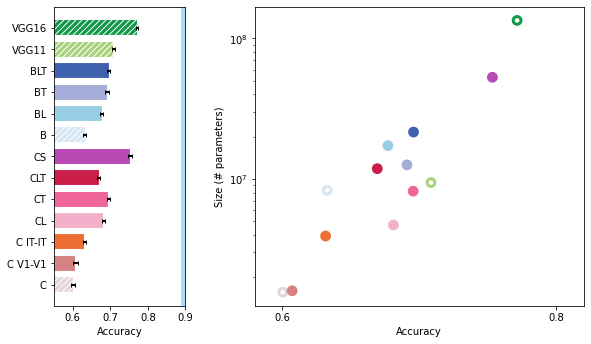

In [ ]:
# Plot model performance x size
fig, ax = plt.subplots(1, 2, figsize=(9.5, 5.5), gridspec_kw={'width_ratios': [2, 5]})

# Create the bar plot values
x_values = range(len(avg_perf_df))
y_values = [avg_perf_df.loc[avg_perf_df['model']==m, 'model_avg_performance'].values[0] for m in avg_perf_df['model']]
# yerr = [(aovavg_perf_df.loc[aovavg_perf_df['model']==m, 'acc']).sem() for m in models] # if choose SEM
yerr = [avg_perf_df.loc[avg_perf_df['model']==m, 'model_ci_seed'].values[0] for m in avg_perf_df['model']] # if choose CI
# Prepare a bar effect to set the edgecolor inwards
# Left side of the plot - bars
bars = ax[0].barh(
    y=x_values,
    width=y_values,
    height=0.7,
    color=[model_palette[m] for m in avg_perf_df['model']],
    linewidth=0.1,
    edgecolor='white',
    hatch=['' if model_architectures[m]=="recurrent" else '////' for m in avg_perf_df['model']],
    xerr = yerr,
    error_kw=err_bar_dict
)
# Add noise ceiling - human average performance
ax[0].axvline(hum_avg_perf,color=hum_col, linewidth=4.0)
# Change the axes
ax[0].set_xlim(0.55, 0.9)
ax[0].set_ylabel(None)
ax[0].set_xlabel('Accuracy')
ax[0].set_yticks(ticks=x_values, labels=[model_names[m] for m in avg_perf_df['model']])
ax[0].set_xticks(ticks=ax[0].get_xticks()[1:])

# Right part of the plot
ax[1].set_ylabel('Size (# parameters)')
ax[1].set_xticks(ticks=ax[1].get_xticks()[1:])
ax[1].set_yscale('log')
ax[1].set_xlabel('Accuracy')
ax[1].set_xlim(0.58, 0.82)
# Make the scatter plot
ax[1].scatter(
    y = avg_perf_df['size'],
    x = y_values,
    color=[model_palette[m] if model_architectures[m]=="recurrent" else 'white' for m in avg_perf_df['model']],
    edgecolor=[model_palette[m] for m in avg_perf_df['model']],
    linewidth=3.0,
    s = marker_size*20
)
# Adjust the distance between plots
plt.subplots_adjust(wspace=0.3)

Reproduce figure 4c.

Text(0.5, 1.0, 'Hard tasks')

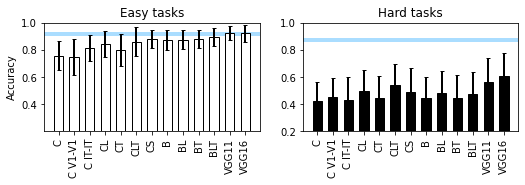

In [45]:
# Plot model accuracy across task difficulty
fig, ax = plt.subplots(1, 2, figsize=(8.5, 2.0))
bar_width = 0.6

# Left side of the plot - easy bars
ax[0].bar(x=range(len(easy_mean)), height=easy_mean, width=bar_width, color='white', edgecolor='black',
               label='Easy tasks', yerr = easy_ci,
               error_kw= err_bar_dict, zorder=2)
# Add noise ceiling - human average performance
ax[0].axhline(hum_avg_perf_nomask,color=hum_col, linewidth=4.0, zorder=0)
# Change the axes
ax[0].set_ylim(0.2, 1.0)
ax[0].set_yticks(ticks=ax[0].get_yticks()[1:])
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(range(len(easy_mean)), labels=[model_names[m] for m in avg_perf_df['model']], rotation = 90)
ax[0].set_title('Easy tasks')

# Right side of the plot - challenging bars
ax[1].bar(x=range(len(hard_mean)), height=hard_mean, width=bar_width, color='black', edgecolor='black',
               label='Hard tasks', yerr = hard_ci,
               error_kw= err_bar_dict, zorder=2)
# Add noise ceiling - human average performance
ax[1].axhline(hum_avg_perf_mask,color=hum_col, linewidth=4.0, zorder=0)
# Change the axes
ax[1].set_ylim(0.2, 1.0)
ax[1].set_xticks(range(len(hard_mean)), labels=[model_names[m] for m in avg_perf_df['model']], rotation = 90)
# Add a title
ax[1].set_title('Hard tasks')